In [34]:
import argparse
import random
import time
import ntpath

import os
import pdb
import sys
sys.path.append("..")

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from latency_predictor.utils import *
from latency_predictor.algs import *
from latency_predictor.nn import NN
from latency_predictor.eval_fns import *
from latency_predictor.featurizer import *
import wandb
import logging
import csv
import yaml
import multiprocessing as mp

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import argparse

def read_flags():
    parser = argparse.ArgumentParser()
    parser.add_argument("--extra_training", type=int,
            required=False,
            default=None, help="")

    parser.add_argument("--min_est", type=float,
            required=False,
            default=None, help="")
    parser.add_argument("--split_kind", type=str,
            required=False,
            default=None, help="")

    parser.add_argument("--latent_variable", type=int,
            required=False,
            default=None, help="")
    parser.add_argument("--latent_inference", type=int,
            required=False,
            default=None, help="")

    parser.add_argument("--batch_size", type=int,
            required=False,
            default=16, help="")
    parser.add_argument("--config", type=str, required=False,
            default="configs/query_splits/imdb/config_trans.yaml", help="")
    
    parser.add_argument("--skip_workload", type=str, required=False,
            default=None, help="")

    parser.add_argument("--sys_seq_kind", type=str, required=False,
            default="rows", help="")

    parser.add_argument("--max_set_len", type=int,
            required=False,
            default=None, help="")

    parser.add_argument("--num_bins", type=int,
            required=False,
            default=None, help="")
    parser.add_argument("--plan_net_num_conv_layers", type=int,
            required=False,
            default=None, help="")

    parser.add_argument("--factorized_net_embedding_size", "-es", type=int,
            required=False,
            default=None, help="")
    parser.add_argument("--factorized_net_arch", type=str,
            required=False,
            default=None, help="")
    parser.add_argument("--factorized_net_finetune_inference", type=int,
            required=False,
            default=None, help="")

    parser.add_argument("--sys_net_pretrained_fn", type=str,
            required=False,
            default=None, help="")
    parser.add_argument("--sys_net_pretrained", type=int,
            required=False,
            default=None, help="")
    parser.add_argument("--factorized_net_pretrained", type=int,
            required=False,
            default=None, help="")

    parser.add_argument("--sys_net_arch", type=str,
            required=False,
            default=None, help="")
    parser.add_argument("--sys_net_max_pool", type=int,
            required=False,
            default=None, help="")

    parser.add_argument("--sys_net_num_layers", type=int,
            required=False,
            default=None, help="")
    parser.add_argument("--sys_net_num_heads", type=int,
            required=False,
            default=None, help="")

    parser.add_argument("--layernorm", type=str, required=False,
            default="post")
    parser.add_argument("--lrscheduler", type=int, required=False,
            default=0)

    parser.add_argument("--actual_feats", type=int, required=False,
            default=0)
    parser.add_argument("--feat_onehot", type=int, required=False,
            default=1)

    parser.add_argument("--table_feat", type=int, required=False,
            default=0, help="1/0; add one-hot features for table in query.")
    parser.add_argument("--col_feat", type=int, required=False,
            default=0, help="1/0; add one-hot features for columns in query.")
    parser.add_argument("--feat_subtree_summary", type=int, required=False,
            default=0, help="")
    parser.add_argument("--feat_undirected_edges", type=int, required=False,
            default=0, help="gcn edges both ways / or directed")
    parser.add_argument("--feat_noncumulative_costs", type=int, required=False,
            default=0)

    parser.add_argument("--subplan_ests", type=int, required=False,
            default=0)

    parser.add_argument("--y_normalizer", type=str, required=False,
            default="", help="none,std,min-max; normalization scheme for target values")
    parser.add_argument("--normalizer", type=str, required=False,
            default="std", help="none,std,min-max; normalization scheme for features.")

    parser.add_argument("--feat_normalization_data", type=str, required=False,
            default="all", help="train,all,wkey; what data to use for normalizing features")
    parser.add_argument("--y_normalization_data", type=str, required=False,
            default="train", help="train,all,wkey")
    parser.add_argument("--final_act", type=str, required=False,
            default="none", help="add a final activation in the models or not.")

    parser.add_argument("--use_wandb", type=int, required=False,
            default=1, help="")
    parser.add_argument("--wandb_tags", type=str, required=False,
            default=None, help="additional tags for wandb logs")

    parser.add_argument("--log_transform_y", type=int, required=False,
            default=1, help="predicting log(latency) instead of latency")

    parser.add_argument("--result_dir", type=str, required=False,
            default="results",
            help="")

    parser.add_argument("--seed", type=int, required=False,
            default=None, help="seed for train/test split")
    parser.add_argument("--num_instances", type=int, required=False,
            default=None, help="seed for train/test split")

    parser.add_argument("--test_size", type=float, required=False,
            default=0.2)

    ## NN parameters
    parser.add_argument("--lr", type=float, required=False,
            default=0.00001)
    parser.add_argument("--weight_decay", type=float, required=False,
            default=0.1)
    parser.add_argument("--hl1", type=int, required=False,
            default=512)
    parser.add_argument("--num_conv_layers", type=int, required=False,
            default=4)
    parser.add_argument("--eval_epoch", type=int, required=False,
            default=2)
    parser.add_argument("--num_epochs", type=int, required=False,
            default=50)

    parser.add_argument("--alg", type=str, required=False,
            default="nn")

    parser.add_argument("--eval_fns", type=str, required=False,
            default="latency_relerr,latency_mse,latency_qerr,latency_ae",
            help="final evaluation functions used to evaluate training alg")

    parser.add_argument("--loss_fn_name", type=str, required=False,
            default="mse")

    parser.add_argument("--arch", type=str, required=False,
            default="factorized", help="tcnn/gcn; architecture of trained neural net.")

    parser.add_argument("--global_feats", type=int, required=False,
            default=0)

    parser.add_argument("--skip_timeouts", type=int, required=False,
            default=1)

    # If no args provided (e.g. when called from Jupyter), use the defaults

    return parser.parse_args([])
    # if args is None:
    #     return parser.parse_args([])
    # else:
    #     return parser.parse_args(args)

# For Jupyter testing:
# args = read_flags()
# print(args)

os.chdir("/flash1/pari/LatencyPredictor/")

In [36]:
def split_workload(df, cfg):

    if args.skip_workload is not None:
        df = df[~df["query_dir"].str.contains(args.skip_workload)]
        print("skipped workload: ", args.skip_workload)

    df = df[df["lt_type"].isin(ALL_INSTANCES)]

    split_kind = cfg.get("split_kind", "instance")

    # inum = cfg.get("instance_num", 1)
    inum = cfg["num_instances"]

    if split_kind in ["instances", "instances-query"]:
        print("Random seed: ", cfg["seed"], " Num Instances: ", inum)
        random.seed(cfg["seed"])
        orig_len = len(df)

        ## background case
        if len(set(df["instance"])) > 20:
            ## so most unique
            tmp = copy.deepcopy(df)
            tmp = tmp[~tmp["query_dir"].str.contains("ceb-small2")]
            num_unique_queries = int(len(set(tmp["qname"])) / 1.5)
            filtered_df = df.groupby('instance').filter(lambda x: \
                    len(set(x["qname"])) >= num_unique_queries)

            after_filter_len = len(filtered_df)
            print("After filtering instance names based on len, {} --> {}"\
                    .format(orig_len, after_filter_len))
        else:
            filtered_df = df

        instances = list(set(filtered_df["instance"]))
        instances.sort()

        if USE_TEST_INSTANCES:
            test_lts = TEST_INSTANCE_TYPES
            tmp = df[df["lt_type"].isin(test_lts)]
            test_qinstances = list(set(tmp["instance"]))
            # choose an instance which has seen all the queries
            rem_instances = [q for q in instances if q not in test_qinstances]
            print("Number of test instances: ", len(test_qinstances))
            print("Number of remaining instances: ", len(rem_instances))
            train_qinstances = random.sample(rem_instances, inum)
            train_qinstances = random.sample(instances, inum)
            assert train_qinstances[0] in instances
        else:
            train_qinstances = random.sample(instances, inum)
            test_qinstances = [q for q in instances if q not in
                    train_qinstances]

        print("Training instances: ", train_qinstances)
        print("Test instances: ", test_qinstances)

        train_df = df[df["instance"].isin(train_qinstances)]
        test_df = df[df["instance"].isin(test_qinstances)]

        if "query" in split_kind:
            # random.seed(cfg["seed"])
            random.seed(42)
            # qnames = list(set(train_df["qname"]))
            qnames = list(set(test_df["qname"]))
            qnames.sort()
            print("All unique qnames: ", len(qnames))
            # split into train / test data
            test_qnames = random.sample(qnames, int(len(qnames)*args.test_size))
            train_qnames = [q for q in qnames if q not in test_qnames]
            train_df = train_df[train_df["qname"].isin(train_qnames)]
            test_df = test_df[test_df["qname"].isin(test_qnames)]
            # print(len(test_df))
            # pdb.set_trace()

    elif split_kind in ["lt_type", "lt_type-query"]:
        print("Random seed: ", cfg["seed"], " Num Instances: ", inum)
        random.seed(cfg["seed"])
        instances = list(set(df["lt_type"]))
        instances.sort()
        print("All instances: ", instances)
        # pdb.set_trace()

        if USE_TEST_INSTANCES:
            test_qinstances = TEST_INSTANCE_TYPES
            non_test_qinstances = [q for q in instances if q not in
                    test_qinstances]
            train_qinstances = random.sample(non_test_qinstances, inum)
            print(train_qinstances)
            # pdb.set_trace()
        else:
            train_qinstances = random.sample(instances, inum)
            test_qinstances = [q for q in instances if q not in
                    train_qinstances]

        print("Training instances: ", train_qinstances)
        print("Test instances: ", test_qinstances)

        train_df = df[df["lt_type"].isin(train_qinstances)]
        test_df = df[df["lt_type"].isin(test_qinstances)]

        if "query" in split_kind:
            # random.seed(cfg["seed"])
            random.seed(42)
            # qnames = list(set(train_df["qname"]))
            qnames = list(set(test_df["qname"]))
            qnames.sort()
            print("All unique qnames: ", len(qnames))
            # pdb.set_trace()
            # split into train / test data
            test_qnames = random.sample(qnames, int(len(qnames)*args.test_size))
            train_qnames = [q for q in qnames if q not in test_qnames]
            train_df = train_df[train_df["qname"].isin(train_qnames)]
            test_df = test_df[test_df["qname"].isin(test_qnames)]

    elif split_kind in ["query_dir", "query_dir-test_instances",
            "query_dir-query", "query_dir-test_instances-query"]:
        test_qdir = cfg["test_query_dir"].split(",")
        train_df = df[~df["query_dir"].isin(test_qdir)]
        test_df = df[df["query_dir"].isin(test_qdir)]

        if "test_instances" in split_kind or USE_TEST_INSTANCES:
            train_df = train_df[train_df["lt_type"].isin(TEST_INSTANCE_TYPES)]
            test_df = test_df[test_df["lt_type"].isin(TEST_INSTANCE_TYPES)]


        if split_kind in ["query_dir-query", "query_dir-test_instances-query"]:
            random.seed(42)
            qnames = list(set(test_df["qname"]))
            qnames.sort()
            test_qnames = random.sample(qnames, int(len(qnames)*args.test_size))
            # train_qnames = [q for q in qnames if q not in test_qnames]
            # train_df = train_df[train_df["qname"].isin(train_qnames)]
            test_df = test_df[test_df["qname"].isin(test_qnames)]
            # print(len(test_df))
            # pdb.set_trace()

    elif split_kind in ["query", "query-test_instances"]:
        random.seed(cfg["seed"])
        qnames = list(set(df["qname"]))
        qnames.sort()
        print("All unique qnames: ", len(qnames))
        # pdb.set_trace()
        # split into train / test data
        random.seed(42)
        test_qnames = random.sample(qnames, int(len(qnames)*args.test_size))

        train_qnames = [q for q in qnames if q not in test_qnames]

        if split_kind == "query-test_instances":
            test_lts = TEST_INSTANCE_TYPES
            df = df[df["lt_type"].isin(test_lts)]
            # test_qinstances = list(set(tmp["instance"]))

        train_df = df[df["qname"].isin(train_qnames)]
        test_df = df[df["qname"].isin(test_qnames)]
    else:
        assert False

    return train_df,test_df


def get_alg(alg, cfg):
    if alg == "avg":
        return AvgPredictor()
    elif alg == "dbms":
        return DBMS(granularity="lt_type", normy=None, only_single=True)
    elif alg == "dbms-c":
        return DBMS(granularity="lt_type", normy=None, only_single=False)
    elif alg == "dbms-c-log":
        return DBMS(granularity="lt_type", normy="log", only_single=False)
    elif alg == "dbms-all":
        return DBMS(granularity="all", normy=None, only_single=False)
    elif alg == "dbms-log":
        return DBMS(granularity="lt_type", normy="log", only_single=False)
    elif alg == "dbms-template-log":
        return DBMS(granularity="template", normy="log", only_single=False)
    elif alg == "dbms-mpl":
        return DBMS(granularity="mpl", normy=None, only_single=False)
    elif alg == "dbms-mpl-log":
        return DBMS(granularity="mpl", normy="log", only_single=False)
    elif alg == "lc":
        return LatencyConverter(
                cfg = cfg,
                lrscheduler=args.lrscheduler,
                result_dir = args.result_dir,
                layernorm=args.layernorm,
                arch = args.arch, hl1 = args.hl1,
                subplan_ests = args.subplan_ests,
                eval_fn_names = args.eval_fns,
                num_conv_layers = args.num_conv_layers,
                final_act = args.final_act,
                use_wandb = args.use_wandb,
                log_transform_y = args.log_transform_y,
                batch_size = args.batch_size,
                global_feats = args.global_feats,
                # tags = args.tags,
                # seed = args.seed,
                test_size = args.test_size,
                # val_size = args.val_size,
                eval_epoch = args.eval_epoch,
                # logdir = args.logdir,
                num_epochs = args.num_epochs,
                lr = args.lr, weight_decay = args.weight_decay,
                loss_fn_name = args.loss_fn_name)

    elif alg == "nn":
        return NN(
                cfg = cfg,
                lrscheduler=args.lrscheduler,
                result_dir = args.result_dir,
                layernorm=args.layernorm,
                arch = args.arch, hl1 = args.hl1,
                subplan_ests = args.subplan_ests,
                eval_fn_names = args.eval_fns,
                num_conv_layers = args.num_conv_layers,
                final_act = args.final_act,
                use_wandb = args.use_wandb,
                log_transform_y = args.log_transform_y,
                batch_size = args.batch_size,
                global_feats = args.global_feats,
                # tags = args.tags,
                # seed = args.seed,
                test_size = args.test_size,
                # val_size = args.val_size,
                eval_epoch = args.eval_epoch,
                # logdir = args.logdir,
                num_epochs = args.num_epochs,
                lr = args.lr, weight_decay = args.weight_decay,
                loss_fn_name = args.loss_fn_name)
    else:
        assert False

def eval_alg(alg, loss_funcs, plans, sys_logs, samples_type):
    '''
    '''
    np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

    loss_start = time.time()
    alg_name = alg.__str__()
    exp_name = alg.get_exp_name()
    start = time.time()

    ests = alg.test(plans, sys_logs)
    truey = [plan.graph["latency"] for plan in plans]
    ests = np.array(ests)
    truey = np.array(truey)

    eval_time = round(time.time() - start, 2)
    print("evaluating alg {} took: {} seconds".format(alg_name, eval_time))

    for loss_func in loss_funcs:
        lossarr = loss_func.eval(ests, truey,
                args=args, samples_type=samples_type,
                )
        worst_idx = np.argpartition(lossarr, -4)[-4:]
        print("***Worst runtime preds for: {}***".format(str(loss_func)))
        print("True: ", np.round(truey[worst_idx], 2))
        print("Ests: ", np.round(ests[worst_idx], 2))

        rdir = os.path.join(args.result_dir, exp_name)
        make_dir(rdir)
        resfn = os.path.join(rdir, loss_func.__str__() + ".csv")

        loss_key = "Final-{}-{}-{}".format(str(loss_func),
                                           samples_type,
                                           "mean")
        wandb.run.summary[loss_key] = np.mean(lossarr)

        loss_median = "Final-{}-{}-{}".format(str(loss_func),
                                           samples_type,
                                           "median")
        wandb.run.summary[loss_median] = np.median(lossarr)

        loss_key2 = "Final-{}-{}-{}".format(str(loss_func),
                                           samples_type,
                                           "99p")
        wandb.run.summary[loss_key2] = np.percentile(lossarr, 99)

        print("tags: {}, samples_type: {}, alg: {}, samples: {}, {}: mean: {}, median: {}, 95p: {}, 99p: {}"\
                .format(cfg["tags"],
                    samples_type, alg, len(lossarr),
                    loss_func.__str__(),
                    np.round(np.mean(lossarr),3),
                    np.round(np.median(lossarr),3),
                    np.round(np.percentile(lossarr,95),3),
                    np.round(np.percentile(lossarr,99),3)))

    print("loss computations took: {} seconds".format(time.time()-loss_start))

def load_dfs(dirs, tags):
    tags = tags.split(",")
    dirs = dirs.split(",")

    all_dfs = []
    sys_logs = {}

    for curdir in dirs:
        for tag in tags:
            cdf,clogs = load_all_logs(tag, curdir,
                    skip_timeouts=args.skip_timeouts)

            if len(clogs) == 0:
                continue

            # TODO: do this in load_all_logs
            # maxlogtime = max(clogs["timestamp"])
            # try:
                # cdf = cdf[cdf["start_time"] <= maxlogtime]
            # except Exception as e:
                # print(tag, e)
                # continue
            assert tag not in sys_logs

            sys_logs[tag] = clogs
            cdf["tag"] = tag
            all_dfs.append(cdf)

    if len(all_dfs) == 0:
        return [],[]

    return pd.concat(all_dfs), sys_logs

cfg = {}
args = read_flags()

global args,cfg

with open(args.config) as f:
    cfg = yaml.safe_load(f.read())

wandbcfg = {}
wandbcfg.update(vars(args))
cargs = vars(args)

for k,v in cfg.items():
    if isinstance(v, dict):
        for k2,v2 in v.items():
            newkey = k+"_"+k2
            if newkey in cargs and cargs[newkey] is not None:
                v[k2] = cargs[newkey]
                v2 = cargs[newkey]
            wandbcfg.update({newkey:v2})
    else:
        if k in cargs and cargs[k] is not None:
            cfg[k] = cargs[k]
            v = cargs[k]
        wandbcfg.update({k:v})

wandb_tags = ["2a"]
if args.wandb_tags is not None:
    wandb_tags += args.wandb_tags.split(",")

if args.use_wandb:
    wandb.init("learned-latency", config=wandbcfg,
            tags=wandb_tags)

print(yaml.dump(cfg, default_flow_style=False))

print("Using tags: ", cfg["tags"].split(","))

df,sys_logs = load_dfs(cfg["traindata_dir"], cfg["tags"])
print(df)

#df = df[df["runtime"] > 2.0]

train_df, test_df = split_workload(df, cfg)
train_plans = get_plans(train_df)
test_plans = get_plans(test_df)

print("Train instance types: ", set(train_df["lt_type"]))
print("Test instance types: ", set(test_df["lt_type"]))
train_qnames = set(train_df["qname"])
test_qnames = set(test_df["qname"])

if cfg["use_eval_tags"]:
    ## new envs
    df,sys_logs2 = load_dfs(cfg["eval_dirs"], cfg["eval_tags"])
    sys_logs.update(sys_logs2)

    seendf = df[df["qname"].isin(train_qnames)]
    unseendf = df[~df["qname"].isin(train_qnames)]

    new_env_seen_plans = get_plans(seendf)
    new_env_unseen_plans = get_plans(unseendf)
else:
    new_env_seen_plans = []
    new_env_unseen_plans = []

print("Training queries: {}, Training plans: {},\
Test queries: {}, Test Plans: {}, New Env Seen Plans: {}\
New Env Unseen Plans: {}".format(
    len(train_qnames), len(train_plans), len(test_qnames),
    len(test_plans),len(new_env_seen_plans),len(new_env_unseen_plans)))

# if args.feat_normalization_data == "train":
#     feat_plans = train_plans
# elif args.feat_normalization_data == "all":
#     feat_plans = train_plans + test_plans + new_env_seen_plans + new_env_unseen_plans

featurizer = Featurizer(train_plans,
                        sys_logs,
                        cfg,
                        sys_seq_kind=args.sys_seq_kind,
                        actual_feats = args.actual_feats,
                        feat_onehot = args.feat_onehot,
                        feat_undirected_edges = args.feat_undirected_edges,
                        feat_noncumulative_costs = args.feat_noncumulative_costs,
                        log_transform_y = args.log_transform_y,
                        global_feats=args.global_feats,
                        # feat_normalization_data=args.feat_normalization_data,
                        y_normalization_data=args.y_normalization_data,
                        feat_subtree_summary = args.feat_subtree_summary,
                        normalizer = args.normalizer,
                        y_normalizer = args.y_normalizer,
                        table_feat=args.table_feat,
                        col_feat = args.col_feat)



alg = get_alg(args.alg, cfg)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


common:
  batch_size: 16
dataset:
  input_test: ''
  input_train: ''
eval_dirs: LatencyCollectorResults/new
eval_tags: exp1_single,exp2_single
factorized_net:
  arch: mlp
  dropout: 0.2
  embedding_size: 128
  heuristic_feats: 0
  hl: 256
  num_layers: 2
  pretrained: 0
latent_inference: 0
latent_variable: 0
max_set_len: 100
num_bins: 25
num_instances: 1
num_latents: 128
plan_net:
  arch: gcn
  dropout: 0.2
  hl: 512
  num_conv_layers: 8
  pretrained: 0
  subplan_ests: 0
random_split: random
seed: 1
split_kind: query
sys_net:
  arch: transformer
  dropout: 0.2
  hl: 512
  log_prev_secs: 600
  log_skip: 2
  max_pool: 1
  num_heads: 16
  num_layers: 2
  pretrained: 0
  pretrained_fn: null
  save_weights: 0
  use_pretrained_norms: 0
tags: exp1_single,exp2_single,exp3_single,exp1,exp4_ceb2,exp7_multi4,exp10_multi4_1p_imdb,exp6_multi4,exp6_multi4b,exp10_multi4_1p_imdb2,exp7_single_ceb2
traindata_dir: LatencyCollectorResults/new,LatencyCollectorResults/background
use_eval_tags: 0

Using tags

In [37]:
# alg.train(train_plans,
#         sys_logs,
#         featurizer,
#         test = test_plans,
#         new_env_seen= new_env_seen_plans,
#         new_env_unseen = new_env_unseen_plans,
#         )

In [38]:
from latency_predictor.dataset import *

ds = QueryPlanDataset(train_plans + test_plans,
                sys_logs,
                featurizer,
                cfg["sys_net"],
                subplan_ests=False
    )

traindl = torch.utils.data.DataLoader(ds,
    batch_size=2,
    shuffle=True,
    collate_fn=alg.collate_fn,
    drop_last=True,
    )

node feature length: 176, global_features: 0


/flash1/pari/LatencyPredictor/Notebooks/../latency_predictor/featurizer.py:520: RuntimeWarning: invalid value encountered in divide
  curfeats = (np.array(curplan.graph["runtime_feats"]) - self.hist_means) \


Skipped 0 plans because sys logs missing


In [ ]:
for data in traindl:
    print(data["info"])
    break

In [41]:

# Assuming `traindl` is an iterable of batches and each batch is a list of dicts.
# Initialize a dictionary to hold the latency data
qname_data = defaultdict(list)
# Step 1: Gather latency values for each qname
for batch in traindl:
    for data in batch["info"]:
        # Collect data into a single list
        qname_data["qname"].append(data["qname"])
        qname_data["lt_type"].append(data["lt_type"])
        qname_data["latency"].append(data["latency"])

# Convert the data into a DataFrame

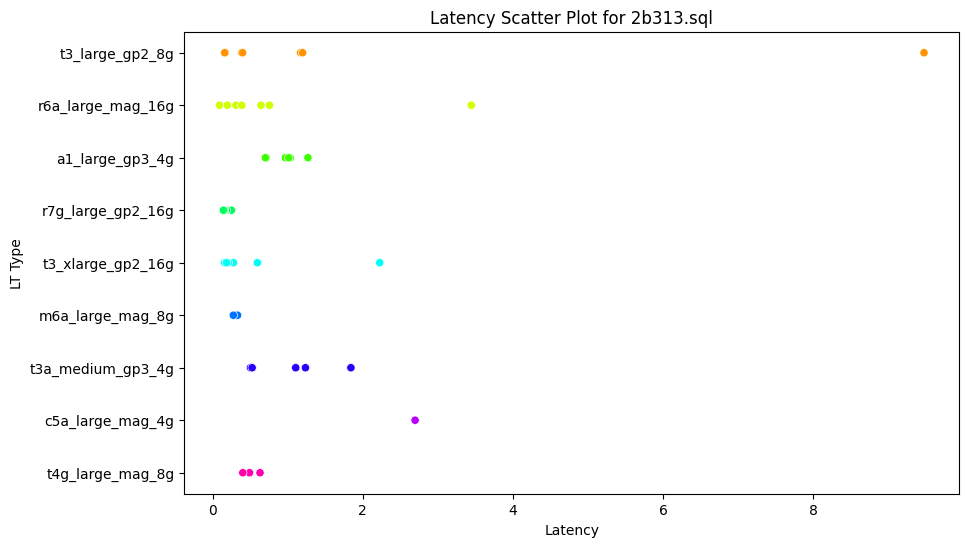

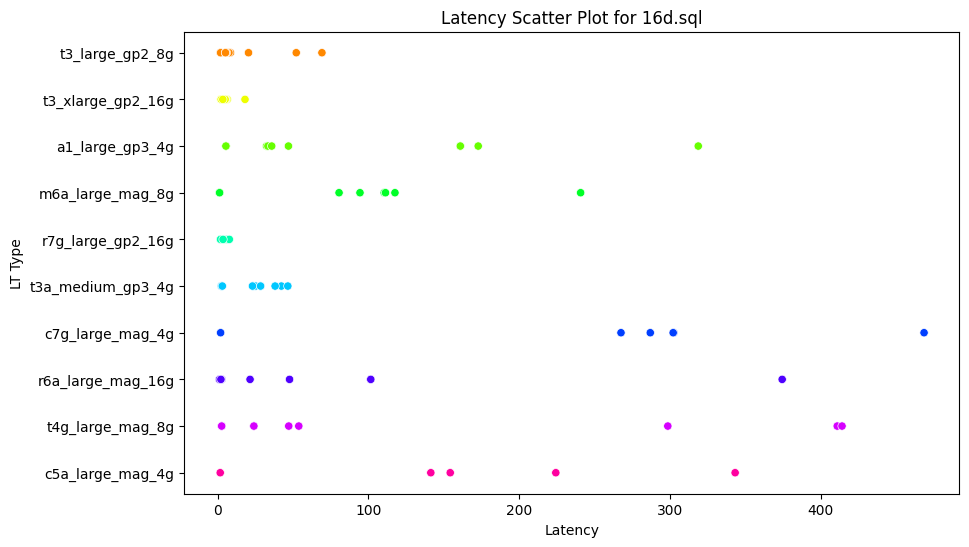

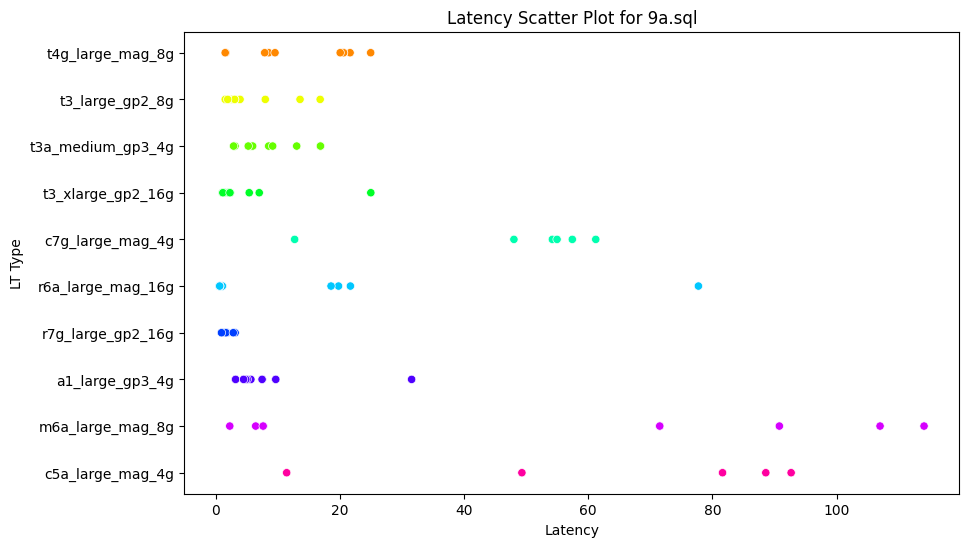

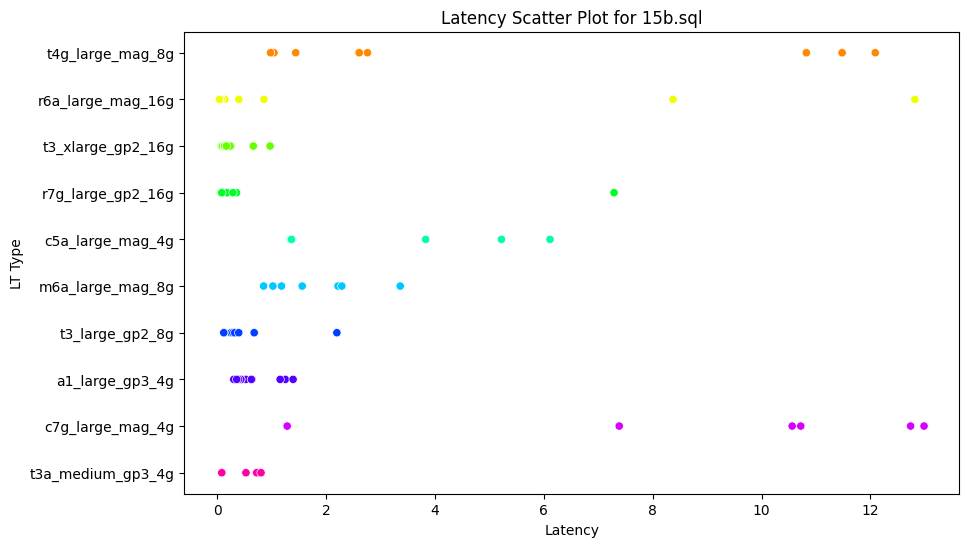

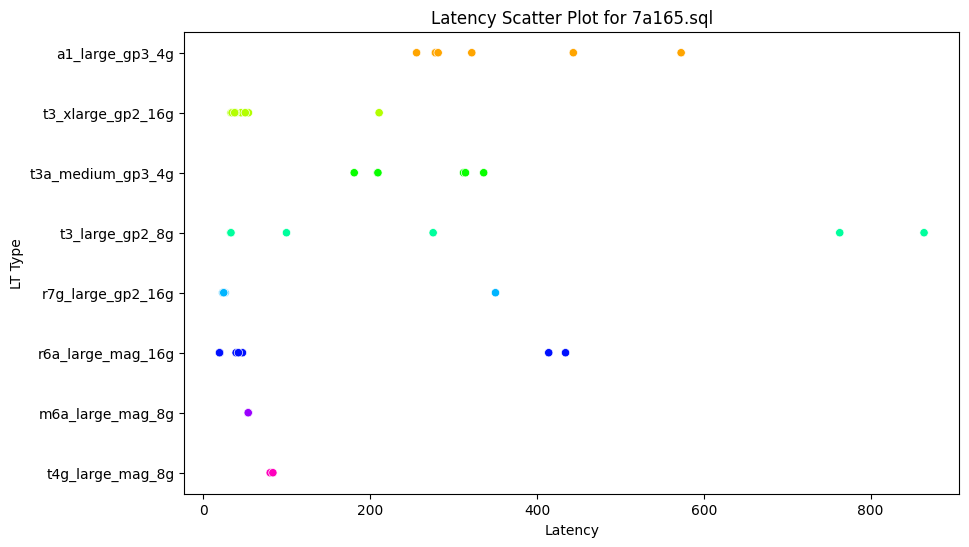

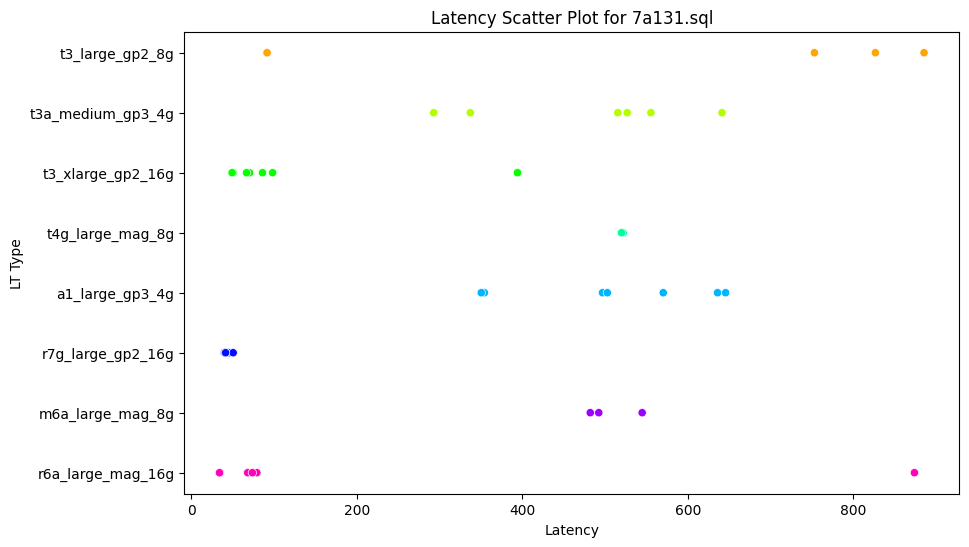

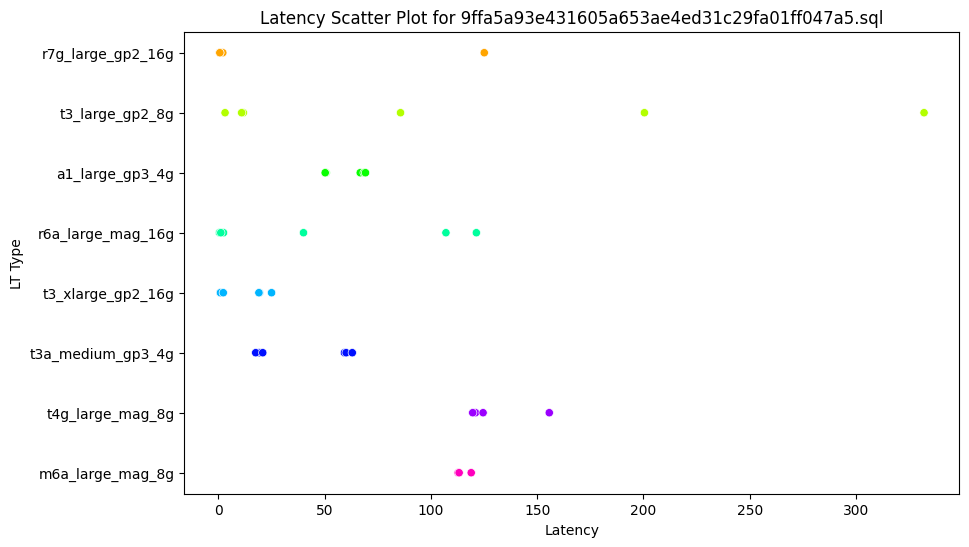

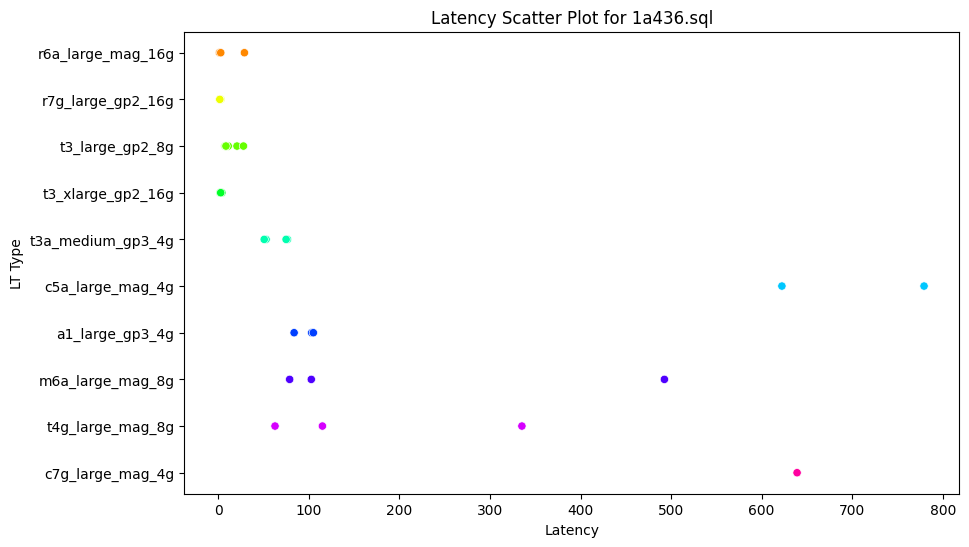

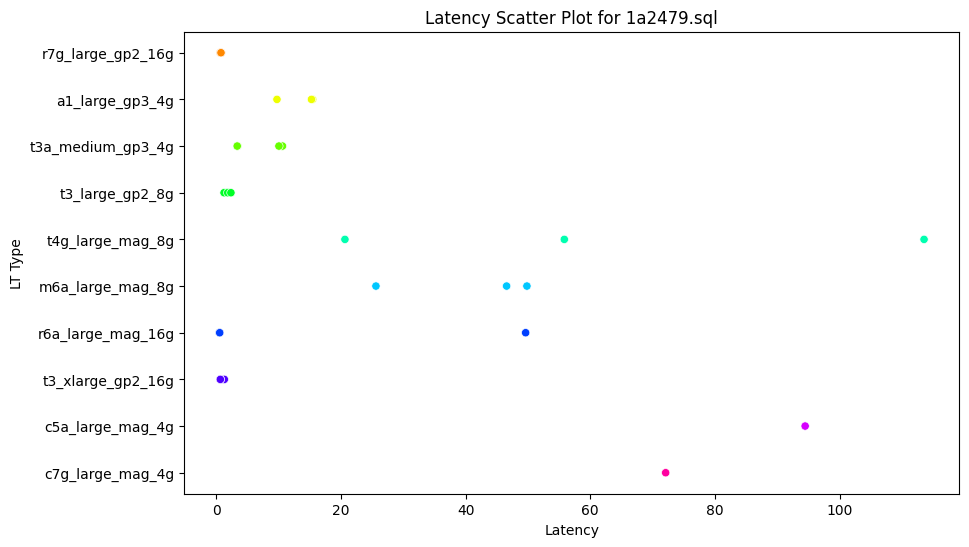

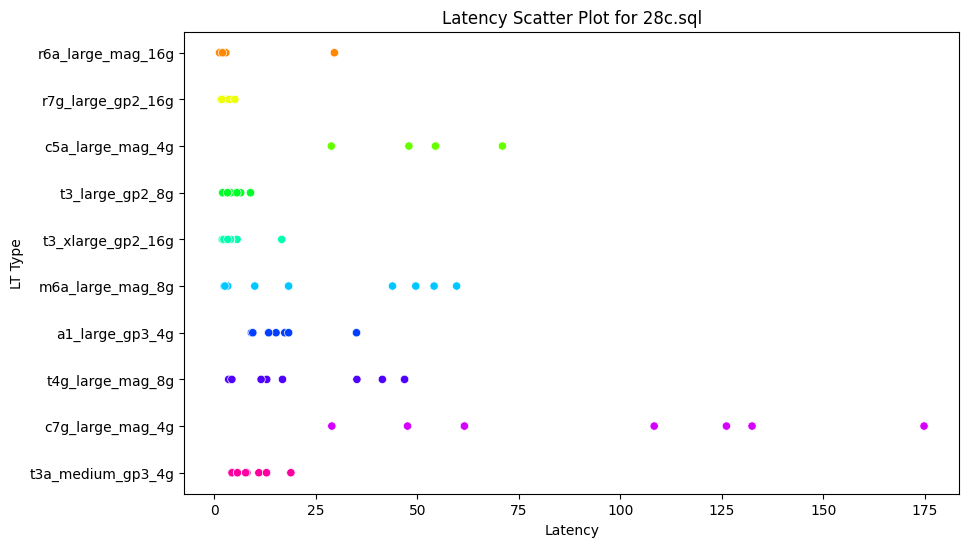

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import random

df = pd.DataFrame(qname_data)

# Step 2: Select 10 random qnames
random_qnames = random.sample(list(df['qname'].unique()), 10)

# Step 3: Create a separate scatterplot for each qname
for qname in random_qnames:
    qname_df = df[df['qname'] == qname]
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=qname_df,
        x="latency",
        y="lt_type",
        hue="lt_type",
        palette="hsv"
    )
    plt.title(f'Latency Scatter Plot for {qname}')
    plt.xlabel('Latency')
    plt.ylabel('LT Type')
    # Removed the legend
    plt.legend().remove()
    plt.show()

In [47]:
# Calculate standard deviation of latency for each qname
qname_std = df.groupby('qname')['latency'].std()

# Define a threshold for high standard deviation, for example:
#high_std_threshold = qname_std.mean() + qname_std.std()  # One standard deviation above the mean

high_std_threshold = qname_std.mean()

# Calculate the proportion of qnames with high standard deviation
high_std_proportion = (qname_std > high_std_threshold).mean()

print(f"Proportion of qnames with high standard deviation in latency: {high_std_proportion:.2f}")

Proportion of qnames with high standard deviation in latency: 0.42


In [44]:
high_std_threshold

144.0231579704266

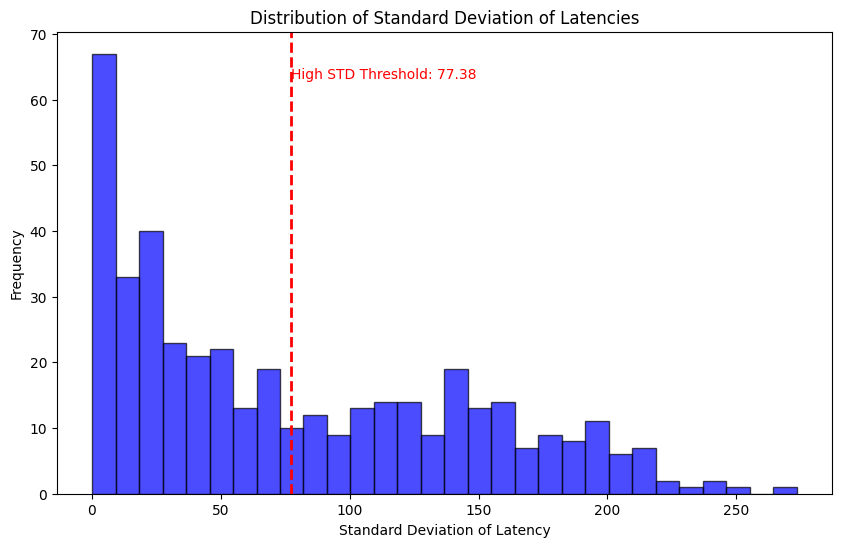

In [46]:
import matplotlib.pyplot as plt

# Calculate standard deviation of latency for each qname
qname_std = df.groupby('qname')['latency'].std()

# Define a threshold for high standard deviation
#high_std_threshold = qname_std.mean() + qname_std.std()  # One standard deviation above the mean
high_std_threshold = qname_std.mean()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(qname_std, bins=30, alpha=0.7, color='blue', edgecolor='black')

# Plot threshold line
plt.axvline(high_std_threshold, color='red', linestyle='dashed', linewidth=2)

# Annotate threshold line
plt.text(high_std_threshold, plt.ylim()[1]*0.9, f'High STD Threshold: {high_std_threshold:.2f}', color='red')

# Title and labels
plt.title('Distribution of Standard Deviation of Latencies')
plt.xlabel('Standard Deviation of Latency')
plt.ylabel('Frequency')

# Show plot

plt.savefig("Latency-dist-no-background.pdf")
plt.show()

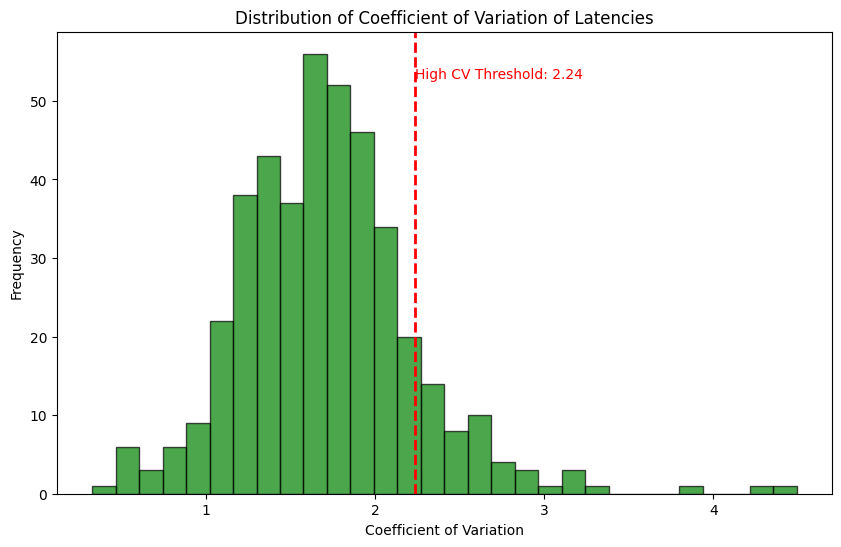

In [48]:
# Calculate the mean and standard deviation for each qname
stats = df.groupby('qname')['latency'].agg(['mean', 'std'])

# Remove potential division by zero and NaNs
stats = stats[(stats['mean'] != 0) & (~np.isnan(stats['std']))]

# Calculate the Coefficient of Variation (CV) for each qname
stats['cv'] = stats['std'] / stats['mean']

# Define a threshold for high CV
high_cv_threshold = stats['cv'].mean() + stats['cv'].std()  # One standard deviation above the mean

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(stats['cv'], bins=30, alpha=0.7, color='green', edgecolor='black')

# Plot threshold line
plt.axvline(high_cv_threshold, color='red', linestyle='dashed', linewidth=2)

# Annotate threshold line
plt.text(high_cv_threshold, plt.ylim()[1]*0.9, f'High CV Threshold: {high_cv_threshold:.2f}', color='red')

# Title and labels
plt.title('Distribution of Coefficient of Variation of Latencies')
plt.xlabel('Coefficient of Variation')
plt.ylabel('Frequency')

# Show plot
plt.show()